<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/3_Layer_Coupling_080723_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3-Layer Model with Informtion, Behavior, Disease

In [18]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#!pip install hypernetx
import hypernetx as hnx

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker


## Part 1: Hypergraph Generation
The following steps generate a hyper graph using the XGI/HyperNetX python package,  following power-law degree distribution for predifined number of nodes n, number of hyperedges num_hyper_edges, degree exponent gamma, using a configuration model with data stored in a dictionary.

In [4]:
# Step 1: Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    # kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

# Step 2: Generate Hyper Edge Size Sequence
def generate_hyper_edge_sizes(degrees, num_hyper_edges):
    total_degrees = sum(degrees)
    hyper_edge_sizes = []

    # Calculate the average size for each hyper edge
    avg_size = total_degrees // num_hyper_edges
    remainder = total_degrees % num_hyper_edges

    # Define the range for the random distribution
    min_size = 2  # Lower bound of the range
    max_size = int(np.sqrt(total_degrees))  # Upper bound of the range
    #max_size = len(degrees) - num_hyper_edges  # Upper bound of the range

    # Generate hyper edge sizes
    for _ in range(num_hyper_edges):
        size = random.randint(min_size, max_size)
        hyper_edge_sizes.append(size)

    return hyper_edge_sizes


# Step 3: Create Copies of Nodes
def create_node_copies(degrees):
    node_copies = []
    for i, degree in enumerate(degrees):
        for _ in range(degree):
            node_copies.append(i)
    return node_copies

# Step 4: Create Copies of Hyper Edges
def create_hyper_edge_copies(hyper_edge_sizes):
    hyper_edge_copies = []
    for i, size in enumerate(hyper_edge_sizes):
        for _ in range(size):
            hyper_edge_copies.append(i)
    return hyper_edge_copies

# Step 5: Randomly Pair Copies without Repeated Pairs
def randomly_pair_copies(node_copies, hyper_edge_copies):
    pairs = []
    paired_hyper_edges = {} # Using a dictionary to track paired hyper-edges with nodes

    for node_copy in node_copies:
        available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # If no available hyper-edges left, shuffle the paired hyper-edges and reset
        if not available_hyper_edges:
            paired_hyper_edges = {}
            available_hyper_edges = [h for h in hyper_edge_copies if (h, node_copy) not in paired_hyper_edges]

        # Randomly choose a hyper-edge that has not been paired yet with the current node
        chosen_hyper_edge = random.choice(available_hyper_edges)
        pairs.append((node_copy, chosen_hyper_edge))

        # Add to paired_hyper_edges
        paired_hyper_edges[(chosen_hyper_edge, node_copy)] = True
        hyper_edge_copies.remove(chosen_hyper_edge)

    return pairs

# Step 6: Convert Bipartite Graph to A Hypergraph Dictionary
def convert_to_hypergraph(pairs):
    hypergraph = {}
    for pair in pairs:
        node, hyper_edge = pair
        if hyper_edge in hypergraph:
            hypergraph[hyper_edge].append(node)
        else:
            hypergraph[hyper_edge] = [node]
    return hypergraph


In [5]:
def build_hypergraph(n, gamma, kmin, num_hyper_edges):
    # Step 1: Generate Degree Sequence
    degrees = generate_degree_sequence(n, gamma, kmin)
    print("Degree Sequence: ", degrees)

    # Step 2: Generate Hyper Edge Size Sequence
    hyper_edge_sizes = generate_hyper_edge_sizes(degrees, num_hyper_edges)
    print("Hyper Edge Sizes: ", hyper_edge_sizes)

    # Step 3: Create Copies of Nodes
    node_copies = create_node_copies(degrees)

    # Step 4: Create Copies of Hyper Edges
    hyper_edge_copies = create_hyper_edge_copies(hyper_edge_sizes)

    # Step 5: Randomly Pair Copies
    pairs = randomly_pair_copies(node_copies, hyper_edge_copies)

    # Step 6: Convert Bipartite Graph to Hypergraph
    hyperedge_dict = convert_to_hypergraph(pairs)

    # Print the resulting hypergraph
    print("Hypergraph Dictionary: ", hyperedge_dict)

    return degrees, hyperedge_dict

In [6]:
# Test 2
n2 =400  # Number of nodes
gamma2 = 2.5  # Power-law exponent
kmin2 = 3  # Minimum degree
num_hyper_edges2 = 100  # Desired number of hyper edges

degrees2, hyperedge_dict2 = build_hypergraph(n2, gamma2, kmin2, num_hyper_edges2)
H2 = hnx.Hypergraph(hyperedge_dict2)

Degree Sequence:  [3, 3, 3, 14, 18, 7, 3, 3, 6, 3, 7, 8, 6, 3, 3, 12, 7, 9, 7, 10, 4, 3, 4, 3, 3, 3, 5, 6, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 7, 4, 3, 4, 3, 3, 3, 17, 4, 5, 3, 7, 14, 4, 3, 4, 3, 6, 13, 3, 4, 8, 3, 3, 5, 3, 4, 3, 5, 4, 17, 4, 3, 4, 4, 4, 3, 4, 6, 3, 9, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 7, 3, 5, 4, 3, 4, 3, 4, 6, 4, 3, 3, 10, 3, 4, 3, 8, 5, 6, 3, 5, 3, 5, 3, 3, 3, 3, 3, 17, 4, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## Part 2: Assign Behavior Status
NP represents the state of no protection, while P represents the state of with protection.

In [7]:
def assign_protection(hypergraph, fraction_protected):
    # Get the list of nodes from the hypergraph
    nodes = list(hypergraph.nodes())

    # Calculate the number of nodes to protect
    num_nodes_to_protect = int(len(nodes) * fraction_protected)

    # Randomly choose nodes to protect
    nodes_to_protect = random.sample(nodes, num_nodes_to_protect)

    # Initialize the protection status dictionary
    protection_status = {}

    # Assign protection status to each node
    for node in nodes:
        if node in nodes_to_protect:
            protection_status[node] = "P"  # Protected node
        else:
            protection_status[node] = "N"  # Non-protected node

    print(protection_status)

    return protection_status

In [8]:
# Test:
fraction_protected = 0.1  # 40% of nodes will be protected
protection_status_dict = assign_protection(H2, fraction_protected)
print(protection_status_dict)

{0: 'N', 1: 'N', 2: 'P', 3: 'N', 4: 'N', 5: 'N', 6: 'N', 7: 'N', 8: 'N', 9: 'N', 10: 'N', 11: 'N', 12: 'N', 13: 'N', 14: 'N', 15: 'N', 16: 'N', 17: 'N', 18: 'N', 19: 'N', 20: 'P', 21: 'P', 22: 'N', 23: 'N', 24: 'N', 25: 'P', 26: 'N', 27: 'N', 28: 'N', 29: 'N', 30: 'N', 31: 'N', 32: 'N', 33: 'N', 34: 'N', 35: 'N', 36: 'P', 37: 'N', 38: 'N', 39: 'N', 40: 'N', 41: 'N', 42: 'N', 43: 'N', 44: 'N', 45: 'N', 46: 'N', 47: 'N', 48: 'N', 49: 'N', 50: 'N', 51: 'P', 52: 'N', 53: 'N', 54: 'N', 55: 'N', 56: 'N', 57: 'N', 58: 'P', 59: 'N', 60: 'N', 61: 'N', 62: 'N', 63: 'N', 64: 'N', 65: 'N', 66: 'N', 67: 'N', 68: 'N', 69: 'N', 70: 'N', 71: 'N', 72: 'N', 73: 'N', 74: 'N', 75: 'N', 76: 'N', 77: 'N', 78: 'N', 79: 'N', 80: 'N', 81: 'N', 82: 'P', 83: 'P', 84: 'N', 85: 'N', 86: 'N', 87: 'N', 88: 'N', 89: 'P', 90: 'N', 91: 'N', 92: 'N', 93: 'N', 94: 'N', 95: 'N', 96: 'P', 97: 'N', 98: 'N', 99: 'N', 100: 'N', 101: 'N', 102: 'N', 103: 'N', 104: 'N', 105: 'N', 106: 'N', 107: 'N', 108: 'N', 109: 'N', 110: 'N',


## Part 3: Assign Threshold
The following steps assigns a threshold value to each node in the network. The threshold follows a uniform or normal distribution with predefined mean (mu) and standard deviation (sigma).

In [9]:
# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph, mu, sigma):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

In [10]:
Ltre2 = assign_thresholds(H2, mu, sigma)

print("Threshold List for Nodes: ", Ltre2 )

Threshold List for Nodes:  {0: 0.05587207618730174, 1: 0.10732538856031418, 2: 0.12673900734207905, 3: 0.12318922448483323, 4: 0.10145245165904372, 5: 0.052532747392947464, 6: 0.04206472384911682, 7: 0.05853889816894691, 8: 0.11184807366762255, 9: 0.09834273962489176, 10: 0.06442779919267905, 11: 0.06289276510275163, 12: 0.04300663408698854, 13: 0.14993198198959506, 14: 0.16954727319630403, 15: 0.1778987646613254, 16: 0.08371127056705055, 17: 0.09278108198377949, 18: 0.15487657132781305, 19: 0.044558569214345506, 20: 0.06088554875610168, 21: 0.11810012837864099, 22: 0.07671806037342256, 23: 0.11699797292751693, 24: 0.15938523445849173, 25: 0.1322249043521067, 26: 0.06379509472251614, 27: 0.09011760552622639, 28: 0.09926493079168372, 29: 0.07028699842915244, 30: 0.17367871548143693, 31: 0.003086234017581624, 32: 0.17868171143349834, 33: 0.1340457304936656, 34: 0.1619933127350963, 35: 0.05006752709035052, 36: 0.13001075629186098, 37: 0.07906056614105385, 38: 0.11189231305796692, 39: 0.19

# Part 4: The ICE Model (The Information Cognition Epidemics Model)
## Information Layer
The misinformation spread occurs on a hyperedge network involving group spreading. The three stages are U(unaware), G(gossip/spreader), and C(stifler/corrected).  

## Cognition Layer
In the cognitive behavioral layer, P is protected, and N is not protected. The rate of transition from state P to N, p, depends on the information layer. The rate from NP to P is 1-p. The transition rate of a node is also affected by the number of active spreader/stiflers. The bigger number of active neighbors, the faster the rate. Another way behavior may change is based on the fraction of protected neighbors.

## Epidemics Layer
In the epidemics layer, the possible disease states are S(susceptible), I(infected), and R(recovered). The illness spreading is pairwise. The disease propagation rate depends on the fraction of protected individuals $\rho_P$.



In [11]:
def ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample):
  """
  Input:
      inw - information hyperedge network
      ltre - list of thresholds for informaiton spread
      ldeg_i - degree sequence of information layer

      cnw - cognitive network
      lprot - list of protection status
      ldeg_c - degree sequence of cognition layer

      enw - epidemic pairwise network
      ldeg_e - degree sequence of epidemic layer

      lambda - information spreading rate
      alp - informaiton stifling rate

      zeta_1 - removing protection rate based on information
      zeta_2 - removing protection rate based on neighborhood behavior
      zeta_1 - adopting protection rate based on information
      zeta_2 - adopting protection rate based on neighborhood behavior

      beta_PP - disease transmission rate between protected S and protected I
      beta_NP - disease transmission rate between not protected S and protected I
      beta_PN - disease transmission rate between protected S and not protected I
      beta_NN - disease transmission rate between not protected S and not protected I

      mu - disease recovery rate

      n_sample - number of samples
  """

  t_max = 100000      # Set maximum time
  kmax_i = max (ldeg_i)     # Get maximum hyperedge degree in information layer
  kmax_c = max (ldeg_c)     # Get maximum hyperedge degree in cognition layer
  kmax_e = max (ldeg_e)     # Get maximum degree in epidemic layer
  N = inw.order()  # Get the network size

  rho_C = []   # Keep track of fraction of corrected in information layer
  rho_P = []   # Keep track of fraction of protected in cognition layer
  rho_R = []   # Keep track of fraction of recovered in epidemic layer

  for i_samp in range(1, n_sample + 1):
      t = 0                 # Initialize time, number of corrected, number of recovered
      N_corrected = 0
      N_recovered = 0

      info_states = {j: "U" for j in inw.nodes()}   # Initialize information and disease states
      disease_states = {k: "S" for k in enw.nodes()}

      protected = list(filter(lambda node: lprot[node] == "P", lprot))
      N_protected = len(protected)
      not_protected = list(filter(lambda node: lprot[node] == "N", lprot))


      gossip = []     # Create lists to store gossip and corrected individuals in information layer
      corrected = []

      rumor_node_0 = np.random.choice(list(inw.nodes()))   # Pick a random person to start misinformaiton spreading
      info_states[rumor_node_0] = "G"
      gossip.append(rumor_node_0)
      N_gossip = 1
      N_e_i = inw.degree(rumor_node_0)

      infected = []     # Create lists to store infected and recovered individuals in epidemic layer
      recovered = []

      ill_node_0 = np.random.choice(list(enw.nodes()))   # Pick a random person to start disease spreading
      disease_states[ill_node_0] = "I"
      infected.append(ill_node_0)
      N_infected = 1
      N_e_e = enw.degree(ill_node_0)

      while N_gossip > 0:   # We stop when there is no infection and no gossip
          total_rate = lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e + mu * N_infected + zeta_1 * N_gossip + zeta_2 * (N-N_gossip) + zeta_3 * (N-N_protected) + zeta_4 * N_protected
          tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
          t += tau

          if t >= t_max:
                break

          # Determine which event occurs
          event = np.random.uniform()
          p1 = (lam * N_e_i) / total_rate     # rumor spreading
          p2 = (lam * N_e_i + alp * N_e_i) / total_rate  # rumor stifling (by meeting stifling neighbor threshold)
          p3 = (lam * N_e_i + 2 * alp * N_e_i) / total_rate  # rumor stifling (by meeting gossip neighbor threshold)

          p4 = (lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e) / total_rate  # disease propagation
          p5 = (lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e + mu * N_infected) / total_rate  # disease recovery

          p6 = (lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e + mu * N_infected + zeta_1 * N_gossip) / total_rate # change to not adopting protection by information
          p7 = (lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e + mu * N_infected + zeta_1 * N_gossip + zeta_2 * (N-N_gossip)) / total_rate # change to adopting protection by information
          p8 = (lam * N_e_i + 2 * alp * N_e_i + beta_NN * N_e_e + mu * N_infected + zeta_1 * N_gossip + zeta_2 * (N-N_gossip) + zeta_3 * (N-N_protected)) / total_rate # change to not adopting protection by neighborhood behavior
          # > p8 # change to adopting protection by neighborhood behavior
          #print(p1, p2, p3, p4, p5, p6, p7, p8)

          # Determine if accept selected individual based on degree distribution
          q_deg_i = np.random.uniform()
          q_deg_c = np.random.uniform()
          q_deg_e = np.random.uniform()

          # Case 1: Rumor spreading
          if event < p1:
                gossip_node = random.choice(gossip)
                if q_deg_i < inw.degree(gossip_node) / kmax_i:
                    rumor_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[rumor_hyper_edge]
                    """
                    while gossip_node not in neighbors:
                        rumor_hyper_edge = np.random.choice(list(inw.edges()))
                        neighbors = inw[rumor_hyper_edge]
                    """
                    MAX_ITERATIONS = 20 # Set a reasonable limit based on your specific case
                    iterations = 0
                    while gossip_node not in neighbors:
                        if iterations > MAX_ITERATIONS:
                           break
                        rumor_hyper_edge = np.random.choice(list(inw.edges()))
                        neighbors = inw[rumor_hyper_edge]
                        iterations += 1

                    for neighbor in neighbors:
                            if info_states[neighbor] == "U":
                                count_gossip_neighbors = sum(1 for node in inw.neighbors(neighbor) if info_states[node] == "G")
                                if count_gossip_neighbors / len(inw.neighbors(neighbor)) >= ltre[neighbor]:
                                    info_states[neighbor] = "G"  # uninformed neighbor becomes gossip spreader
                                    gossip.append(neighbor)
                                    N_gossip += 1



          # Case 2: Rumor stifling (by meeting stifling neighbor threshold)
          elif event < p2:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node)  / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_stifler_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "C")
                    if count_stifler_neighbors / len(neighbors) >= ltre[stifler_node]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1

          # Case 3: Rumor stifling (by meeting gossip neighbor threshold)
          elif event < p3:
            #if N_gossip > 0:
                stifler_node = np.random.choice(gossip)
                if q_deg_i < inw.degree(stifler_node) / kmax_i:
                    stifler_hyper_edge = np.random.choice(list(inw.edges()))
                    neighbors = inw[stifler_hyper_edge]
                    count_gossip_neighbors = sum(1 for node in inw.neighbors(stifler_node) if info_states[node] == "G")
                    if count_gossip_neighbors / len(neighbors) >= ltre[stifler_node]:
                            info_states[stifler_node] = "C"
                            N_gossip -= 1
                            gossip.remove(stifler_node)
                            corrected.append(stifler_node)
                            N_corrected += 1

          # Case 4: Disease propagation
          elif event < p4:
            if N_infected > 0:
              infected_node = np.random.choice(infected)
              infected_protected = lprot[infected_node]
              neighbors = list(enw.neighbors(infected_node))
              susceptible_neighbors = [n for n in neighbors if disease_states[n] == "S"]

              if len(susceptible_neighbors) > 0:
                  neighbor = np.random.choice(susceptible_neighbors)
                  neighbor_protected = lprot[neighbor]

                  # Determine the appropriate transmission rate based on protection status
                  if neighbor_protected == "P" and infected_protected == "P":
                            transmission_rate = beta_PP/beta_NN
                  elif neighbor_protected == "N" and infected_protected == "P":
                            transmission_rate = beta_NP/beta_NN
                  elif neighbor_protected == "P" and infected_protected == "N":
                            transmission_rate = beta_PN/beta_NN
                  else:
                            transmission_rate = beta_NN/beta_NN

                  if np.random.uniform() < transmission_rate:
                      disease_states[neighbor] = "I"
                      infected.append(neighbor)
                      N_infected += 1
                      N_e_e += enw.degree(neighbor)

          # Case 5: Disease recovery
          elif event < p5:
            if N_infected > 0:
                recovered_node = np.random.choice(infected)
                if q_deg_e < ldeg_e[recovered_node]/kmax_e:
                    disease_states[recovered_node] = "R"
                    infected.remove(recovered_node)
                    recovered.append(recovered_node)
                    N_infected -= 1
                    N_recovered += 1
                    N_e_e -= enw.degree(recovered_node)

          # Case 6: # Change to not adopting protection based on information layer
          # rate = zeta_1 * n_G / k_info
          # n_G is the total spreader neighbors on the information layer,
          # while k_info is the total neighbor count on the information layer
          elif event < p6:
            if len(protected) > 0:
              node_to_not_protect = np.random.choice(protected)
              n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_not_protect)))
              k_info = len(inw.neighbors(node_to_not_protect))
              if np.random.uniform() < zeta_1 * n_G / k_info:
                    lprot[node_to_not_protect] = "N"
                    protected.remove(node_to_not_protect)
                    not_protected.append(node_to_not_protect)
                    N_protected -= 1

          # Case 7: Change to adopting protection based on information layer
          # rate = zeta_2 * (1 - n_G / k_info)
          elif event < p7:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_G = sum(1 for node in filter(lambda x: info_states[x] == "G", inw.neighbors(node_to_protect)))
                k_info = len(inw.neighbors(node_to_protect))
                if np.random.uniform() < zeta_2 * (1 - n_G / k_info):
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1


          # Case 8: # Change to not adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_3 * (1 - n_P / k_cog)
          # n_P is the total protected neighbors on the cognition layer,
          # while k_cog is the total neighbor count on the cognition layer
          elif event < p8:
            if len(protected) > 0:
                node_to_not_protect = np.random.choice(protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_not_protect)))
                k_cog = len(cnw.neighbors(node_to_not_protect))
                if np.random.uniform() < zeta_3 * (1 - n_P / k_cog):
                        lprot[node_to_not_protect] = "N"
                        protected.remove(node_to_not_protect)
                        not_protected.append(node_to_not_protect)
                        N_protected -= 1


          # Case 9: # Change to adopting protection based on neighborhood behavior in cognition layer
          # rate = zeta_4 * n_P / k_cog
          else:
            if len(not_protected) > 0:
                node_to_protect = np.random.choice(not_protected)
                n_P = sum(1 for node in filter(lambda x: lprot[x] == "P", cnw.neighbors(node_to_protect)))
                k_cog = len(cnw.neighbors(node_to_protect))
                if np.random.uniform() < zeta_4 * n_P / k_cog:
                        lprot[node_to_protect] = "P"
                        not_protected.remove(node_to_protect)
                        protected.append(node_to_protect)
                        N_protected += 1
      #print("N_infected", N_infected, "N_gossip", N_gossip)
      if N_infected == 0:
          corrected_frac = N_corrected / N
          protected_frac = N_protected / N
          recovered_frac = N_recovered / N
          rho_C.append(corrected_frac)
          rho_P.append(protected_frac)
          rho_R.append(recovered_frac)
          #print("corrected_frac", corrected_frac, "recovered_frac", recovered_frac)

  avg_rho_C = sum(rho_C) / len(rho_C)
  avg_rho_P = sum(rho_P) / len(rho_P)
  avg_rho_R = sum(rho_R) / len(rho_R)

  return avg_rho_C, avg_rho_P, avg_rho_R


In [14]:
n = 400  # Number of nodes

# Information Layer
gamma_i = 2.5  # Power-law exponent
kmin_i = 3  # Minimum degree
num_hyper_edges_i = 100  # Desired number of hyper edges
ldeg_i, hyperedge_dict_i = build_hypergraph(n, gamma_i, kmin_i, num_hyper_edges_i)
inw = hnx.Hypergraph(hyperedge_dict_i)
ltre = assign_thresholds(inw, 0.05, 0.03)

# Cognition Layer
gamma_c = 3.0  # Power-law exponent
kmin_c = 3  # Minimum degree
num_hyper_edges_c = 100  # Desired number of hyper edges
ldeg_c, hyperedge_dict_c = build_hypergraph(n, gamma_c, kmin_c, num_hyper_edges_c)
cnw = hnx.Hypergraph(hyperedge_dict_c)
frac_prot = 0.1
lprot = assign_protection(cnw, frac_prot)

# Epidemic Layer
gamma_e = 4.0
kmin_e = 3
ldeg_e = generate_degree_sequence(n, gamma_e, kmin_e)
print("Degree Sequence: ", ldeg_e)
enw = nx.configuration_model(ldeg_e)

Degree Sequence:  [7, 4, 3, 3, 4, 6, 3, 3, 4, 3, 4, 3, 9, 3, 3, 3, 10, 5, 3, 3, 7, 8, 8, 10, 4, 5, 4, 4, 5, 7, 3, 4, 3, 8, 5, 3, 8, 5, 4, 5, 3, 3, 3, 3, 4, 3, 3, 7, 5, 4, 3, 14, 3, 3, 3, 5, 3, 9, 3, 6, 4, 3, 6, 5, 9, 3, 5, 18, 6, 3, 3, 3, 3, 3, 7, 4, 14, 3, 3, 3, 3, 3, 4, 7, 3, 3, 4, 3, 3, 6, 6, 3, 3, 10, 5, 3, 3, 3, 3, 3, 7, 6, 3, 5, 3, 6, 4, 3, 3, 5, 3, 4, 3, 4, 5, 3, 8, 4, 3, 4, 3, 8, 3, 4, 3, 3, 6, 12, 3, 3, 3, 3, 3, 3, 10, 3, 6, 11, 3, 4, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
lam = 0.1
alp = 1
zeta_1 = 0.1
zeta_3 = 0.1
beta_PP = 0.025
beta_NP = 0.05
beta_PN = 0.2
beta_NN = 0.4
mu = 1
n_sample = 30

# Set the SN-IP and SP-IN disease spreading rates
zeta_2_values = np.arange(0.05, 0.25, 0.05)
zeta_4_values = np.arange(0.05, 0.25, 0.05)

# Initialize the result array
results_rho_C = np.zeros((len(zeta_2_values), len(zeta_4_values)))
results_rho_R = np.zeros((len(zeta_2_values), len(zeta_4_values)))

# Iterate over mu and lambda values
for i, zeta_2 in enumerate(zeta_2_values):
    for j, zeta_4 in enumerate(zeta_4_values):
        avg_rho_C, avg_rho_P, avg_rho_R = ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)
        results_rho_C[i, j] = avg_rho_C
        results_rho_R[i, j] = avg_rho_R
        print("zeta_2:", zeta_2, "zeta_4:", zeta_4, "rho_C:", avg_rho_C, "rho_R:", avg_rho_R)

corrected_frac 0.035 recovered_frac 0.8625
corrected_frac 0.9675 recovered_frac 0.0025
corrected_frac 0.9925 recovered_frac 0.89
corrected_frac 0.985 recovered_frac 0.8625
corrected_frac 0.0225 recovered_frac 0.02
corrected_frac 0.0275 recovered_frac 0.0025
corrected_frac 0.01 recovered_frac 0.905
corrected_frac 0.9875 recovered_frac 0.0175
corrected_frac 0.98 recovered_frac 0.8625
corrected_frac 0.9975 recovered_frac 0.8825
corrected_frac 0.02 recovered_frac 0.0025
corrected_frac 0.9625 recovered_frac 0.84
corrected_frac 1.0 recovered_frac 0.8475
corrected_frac 0.995 recovered_frac 0.005
corrected_frac 0.995 recovered_frac 0.0025
corrected_frac 0.9975 recovered_frac 0.0025
corrected_frac 0.9975 recovered_frac 0.9425
corrected_frac 0.975 recovered_frac 0.915
corrected_frac 0.055 recovered_frac 0.8675
corrected_frac 0.99 recovered_frac 0.8725
corrected_frac 0.995 recovered_frac 0.01
corrected_frac 1.0 recovered_frac 0.835
corrected_frac 0.99 recovered_frac 0.79
corrected_frac 0.035 reco

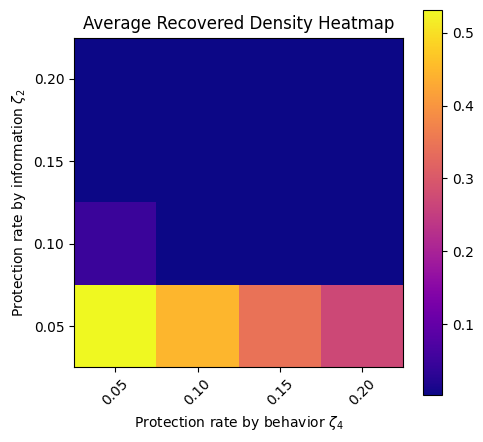

In [ ]:
# Plot the heat map
fig, ax = plt.subplots(figsize=(5,5))
heatmap = ax.imshow(results_rho_R, cmap='plasma', interpolation='nearest')

# Set the tick labels and show colorbar
ax.set_xticks(np.arange(len(zeta_4_values)))
ax.set_yticks(np.arange(len(zeta_2_values)))

# Format the tick labels with two decimal places using string formatting
zeta_4_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
zeta_2_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
ax.xaxis.set_major_formatter(zeta_4_formatter)
ax.yaxis.set_major_formatter(zeta_2_formatter)
ax.invert_yaxis()

ax.set_xticklabels(['{:.2f}'.format(val) for val in zeta_4_values])
ax.set_yticklabels(['{:.2f}'.format(val) for val in zeta_2_values])

plt.xticks(rotation=45)
plt.colorbar(heatmap, fraction=0.1)

# Set labels and title
ax.set_xlabel('Protection rate by behavior $\zeta_4$')
ax.set_ylabel('Protection rate by information $\zeta_2$')
ax.set_title('Average Recovered Density Heatmap')

# Display the heat map
plt.show()

In [ ]:
lam = 0.1
alp = 1
zeta_1 = 0.1
zeta_3 = 0.1
beta_PP = 0.025
beta_NP = 0.05
beta_PN = 0.2
beta_NN = 0.4
mu = 1
n_sample = 50

# Set the SN-IP and SP-IN disease spreading rates
zeta_2_values = np.arange(0.05, 0.20, 0.05)
zeta_4_values = np.arange(0.05, 0.25, 0.05)

# Initialize the result array
results_rho_C = np.zeros((len(zeta_2_values), len(zeta_4_values)))
results_rho_R = np.zeros((len(zeta_2_values), len(zeta_4_values)))

# Iterate over mu and lambda values
for i, zeta_2 in enumerate(zeta_2_values):
    for j, zeta_4 in enumerate(zeta_4_values):
        avg_rho_C, avg_rho_P, avg_rho_R = ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)
        results_rho_C[i, j] = avg_rho_C
        results_rho_R[i, j] = avg_rho_R
        print("zeta_2:", zeta_2, "zeta_4:", zeta_4, "rho_C:", avg_rho_C, "rho_R:", avg_rho_R)

zeta_2: 0.05 zeta_4: 0.05 rho_C: 0.5889772727272726 rho_R: 0.5909659090909092
zeta_2: 0.05 zeta_4: 0.1 rho_C: 0.6638068181818181 rho_R: 0.564375
zeta_2: 0.05 zeta_4: 0.15000000000000002 rho_C: 0.689095744680851 rho_R: 0.5556382978723406
zeta_2: 0.05 zeta_4: 0.2 rho_C: 0.5742934782608694 rho_R: 0.5048369565217392
zeta_2: 0.1 zeta_4: 0.05 rho_C: 0.7116326530612246 rho_R: 0.06045918367346932
zeta_2: 0.1 zeta_4: 0.1 rho_C: 0.5708500000000001 rho_R: 0.0027000000000000014
zeta_2: 0.1 zeta_4: 0.15000000000000002 rho_C: 0.596 rho_R: 0.0031500000000000018
zeta_2: 0.1 zeta_4: 0.2 rho_C: 0.5042499999999999 rho_R: 0.0029500000000000017
zeta_2: 0.15000000000000002 zeta_4: 0.05 rho_C: 0.5762755102040815 rho_R: 0.0028061224489795934
zeta_2: 0.15000000000000002 zeta_4: 0.1 rho_C: 0.6299499999999999 rho_R: 0.0028000000000000013
zeta_2: 0.15000000000000002 zeta_4: 0.15000000000000002 rho_C: 0.6087 rho_R: 0.0028000000000000013
zeta_2: 0.15000000000000002 zeta_4: 0.2 rho_C: 0.5248469387755103 rho_R: 0.002

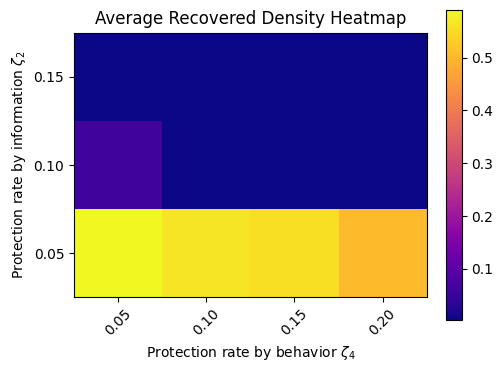

In [ ]:
# Plot the heat map
fig, ax = plt.subplots(figsize=(5,5))
heatmap = ax.imshow(results_rho_R[0:3,:], cmap='plasma', interpolation='nearest')

# Set the tick labels and show colorbar
ax.set_xticks(np.arange(len(zeta_4_values)))
ax.set_yticks(np.arange(len(zeta_2_values[0:3])))

# Format the tick labels with two decimal places using string formatting
zeta_4_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
zeta_2_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
ax.xaxis.set_major_formatter(zeta_4_formatter)
ax.yaxis.set_major_formatter(zeta_2_formatter)
ax.invert_yaxis()

ax.set_xticklabels(['{:.2f}'.format(val) for val in zeta_4_values])
ax.set_yticklabels(['{:.2f}'.format(val) for val in zeta_2_values[0:3]])

plt.xticks(rotation=45)
plt.colorbar(heatmap, fraction=0.04)

# Set labels and title
ax.set_xlabel('Protection rate by behavior $\zeta_4$')
ax.set_ylabel('Protection rate by information $\zeta_2$')
ax.set_title('Average Recovered Density Heatmap')

# Display the heat map
plt.show()

In [16]:
lam = 0.1
alp = 1
zeta_2 = 0.1
zeta_4 = 0.1
beta_PP = 0.025
beta_NP = 0.05
beta_PN = 0.2
beta_NN = 0.4
mu = 1
n_sample = 50

# Set the SN-IP and SP-IN disease spreading rates
zeta_1_values = np.arange(0.15, 0.35, 0.05)
zeta_3_values = np.arange(0.05, 0.25, 0.05)

# Initialize the result array
results_rho_C2 = np.zeros((len(zeta_1_values), len(zeta_3_values)))
results_rho_R2 = np.zeros((len(zeta_1_values), len(zeta_3_values)))

# Iterate over mu and lambda values
for i, zeta_1 in enumerate(zeta_1_values):
    for j, zeta_3 in enumerate(zeta_3_values):
        avg_rho_C2, avg_rho_P2, avg_rho_R2 = ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)
        results_rho_C2[i, j] = avg_rho_C2
        results_rho_R2[i, j] = avg_rho_R2
        print("zeta_1:", zeta_1, "zeta_3:", zeta_3, "rho_C:", avg_rho_C2, "rho_R:", avg_rho_R2)

zeta_1: 0.15 zeta_3: 0.05 rho_C: 0.6682000000000001 rho_R: 0.0028500000000000014
zeta_1: 0.15 zeta_3: 0.1 rho_C: 0.6741000000000001 rho_R: 0.0031500000000000018
zeta_1: 0.15 zeta_3: 0.15000000000000002 rho_C: 0.5643499999999999 rho_R: 0.003100000000000001
zeta_1: 0.15 zeta_3: 0.2 rho_C: 0.5523999999999999 rho_R: 0.0028500000000000014
zeta_1: 0.2 zeta_3: 0.05 rho_C: 0.5212499999999999 rho_R: 0.0032500000000000016
zeta_1: 0.2 zeta_3: 0.1 rho_C: 0.7000000000000002 rho_R: 0.21765306122448977


KeyboardInterrupt: ignored

In [1]:
# Plot the heat map
fig, ax = plt.subplots(figsize=(5,5))
heatmap = ax.imshow(results_rho_R2, cmap='plasma', interpolation='nearest')

# Set the tick labels and show colorbar
ax.set_xticks(np.arange(len(zeta_3_values)))
ax.set_yticks(np.arange(len(zeta_1_values)))

# Format the tick labels with two decimal places using string formatting
zeta_3_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
zeta_1_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
ax.xaxis.set_major_formatter(zeta_3_formatter)
ax.yaxis.set_major_formatter(zeta_1_formatter)
ax.invert_yaxis()

ax.set_xticklabels(['{:.2f}'.format(val) for val in zeta_3_values])
ax.set_yticklabels(['{:.2f}'.format(val) for val in zeta_1_values])

plt.xticks(rotation=45)
plt.colorbar(heatmap, fraction=0.1)

# Set labels and title
ax.set_xlabel('Protection rate by behavior $\zeta_3$')
ax.set_ylabel('Protection rate by information $\zeta_1$')
ax.set_title('Average Recovered Density Heatmap')

# Display the heat map
plt.show()

NameError: ignored

In [17]:
lam = 0.1
alp = 1
zeta_2 = 0.1
zeta_4 = 0.1
beta_PP = 0.025
beta_NP = 0.05
beta_PN = 0.2
beta_NN = 0.4
mu = 1
n_sample = 50

# Set the SN-IP and SP-IN disease spreading rates
zeta_1_values2 = np.arange(0.05, 0.21, 0.05)
zeta_3_values2 = np.arange(0.05, 0.21, 0.05)

# Initialize the result array
results_rho_C3 = np.zeros((len(zeta_1_values2), len(zeta_3_values2)))
results_rho_R3 = np.zeros((len(zeta_1_values2), len(zeta_3_values2)))

# Iterate over mu and lambda values
for i, zeta_1 in enumerate(zeta_1_values2):
    for j, zeta_3 in enumerate(zeta_3_values2):
        avg_rho_C3, avg_rho_P3, avg_rho_R3 = ICE_model(inw, ldeg_i, ltre, cnw, ldeg_c, lprot, enw, ldeg_e, lam, alp, zeta_1, zeta_2, zeta_3, zeta_4, beta_PP, beta_NP, beta_PN, beta_NN, mu, n_sample)
        results_rho_C3[i, j] = avg_rho_C3
        results_rho_R3[i, j] = avg_rho_R3
        print("zeta_1:", zeta_1, "zeta_3:", zeta_3, "rho_C:", avg_rho_C3, "rho_R:", avg_rho_R3)

zeta_1: 0.05 zeta_3: 0.05 rho_C: 0.6228499999999998 rho_R: 0.020249999999999956
zeta_1: 0.05 zeta_3: 0.1 rho_C: 0.5643 rho_R: 0.0033000000000000017
zeta_1: 0.05 zeta_3: 0.15000000000000002 rho_C: 0.6772448979591837 rho_R: 0.0030102040816326545
zeta_1: 0.05 zeta_3: 0.2 rho_C: 0.5485500000000001 rho_R: 0.0029000000000000015
zeta_1: 0.1 zeta_3: 0.05 rho_C: 0.6456999999999999 rho_R: 0.003100000000000001
zeta_1: 0.1 zeta_3: 0.1 rho_C: 0.6015625 rho_R: 0.0031250000000000015
zeta_1: 0.1 zeta_3: 0.15000000000000002 rho_C: 0.5581499999999999 rho_R: 0.003400000000000002
zeta_1: 0.1 zeta_3: 0.2 rho_C: 0.6033500000000002 rho_R: 0.0029500000000000017
zeta_1: 0.15000000000000002 zeta_3: 0.05 rho_C: 0.5368499999999999 rho_R: 0.0028500000000000014
zeta_1: 0.15000000000000002 zeta_3: 0.1 rho_C: 0.64225 rho_R: 0.056400000000000006
zeta_1: 0.15000000000000002 zeta_3: 0.15000000000000002 rho_C: 0.7846428571428571 rho_R: 0.002908163265306124
zeta_1: 0.2 zeta_3: 0.05 rho_C: 0.6176020408163264 rho_R: 0.00326

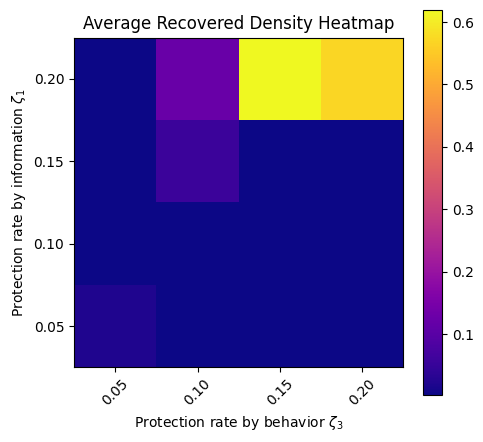

In [19]:
# Plot the heat map
fig, ax = plt.subplots(figsize=(5,5))
heatmap = ax.imshow(results_rho_R3, cmap='plasma', interpolation='nearest')

# Set the tick labels and show colorbar
ax.set_xticks(np.arange(len(zeta_3_values2)))
ax.set_yticks(np.arange(len(zeta_1_values2)))

# Format the tick labels with two decimal places using string formatting
zeta_3_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
zeta_1_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
ax.xaxis.set_major_formatter(zeta_3_formatter)
ax.yaxis.set_major_formatter(zeta_1_formatter)
ax.invert_yaxis()

ax.set_xticklabels(['{:.2f}'.format(val) for val in zeta_3_values2])
ax.set_yticklabels(['{:.2f}'.format(val) for val in zeta_1_values2])

plt.xticks(rotation=45)
plt.colorbar(heatmap, fraction=0.1)

# Set labels and title
ax.set_xlabel('Protection rate by behavior $\zeta_3$')
ax.set_ylabel('Protection rate by information $\zeta_1$')
ax.set_title('Average Recovered Density Heatmap')

# Display the heat map
plt.show()